## Projet de cursus: Malware detection algorithm
#### Author:  Masson Pierre 

**Malware dynamic detection training model--API analysis**

We focus our view of the analysis to behavioral analysis, we observe the sequence of API calls. Each API call sequence is composed of the first 100 non-repeated consecutive API calls associated with the parent process.

According to Ficco, M. https://www.researchgate.net/publication/340275184_Comparing_API_Call_Sequence_Algorithms_for_Malware_Detection :

**"Malware became more and more sophisticated and increasingly difficult to detect, thanks to the use of evasion techniques, including anti-emulation, encapsulation, obfuscation, packing, anti-virtualization, and anti-debugger. New malware variants are generated by removing, replacing, and adding useless API calls to the malicious code. To face this increasing number of malware, it is necessary to design new detection methods, which are in charge of quickly analyzing large dataset and its variants."**

We perform classification of malware and benign samples based on their runtime behavior. Our first three steps are to define a function to read in and parse the JSON logs that contain information about the samples runtime behavior. 

***JSON is a useful file format whenever your data might have a
variable number of attributes***. 

We make the strategic choice to extract the API call class,
method, and content. Other features are available as well, such as the time at which the API
call was made and what arguments were called. The trade-off is that the dataset will be
larger and these features might cause a slowdown or overfit. 

we load our N-gram extraction functions and use these to extract N-grams from our dataset. These extraction methods are similar to the ones used for binary files, but adjusted for the text format at hand. Initially, we collect the K1=3000 most frequent N-grams in order to reduce the computational load. By increasing the numbers K1 and, later on, K2, we can expect the accuracy of our classifier to improve, but the memory and computational requirements to increase 

we need to define a function to featurize the samples into their N-gram feature vectors, and then, we
apply this function to featurize our training and testing samples. We would like to narrow
down our feature set further. We choose to use mutual information to select the **K2=500**.


In [1]:
import numpy as np
import os
import json

In [2]:
directories_with_labels = [("Benign", 0), ("Malware", 1)]

In [3]:
def get_API_class_method_type_from_log(log):
    API_data_sequence = []
    with open(log) as log_file:
        json_log = json.load(log_file)
        api_calls_array = "[" + json_log["api_calls"] + "]"
        api_calls = json.loads(api_calls_array)
        for api_call in api_calls:
            data = api_call["class"] + ":" + api_call["method"] + ":" + api_call["type"]
            API_data_sequence.append(data)
    return API_data_sequence

In [4]:
data_corpus = []
labels = []
for directory, label in directories_with_labels:
    logs = os.listdir(directory)
    for log_path in logs:
        file_path = directory + "/" + log_path
        try:
            data_corpus.append(get_API_class_method_type_from_log(file_path))
            labels.append(label)
        except:
            pass

In [5]:
print(data_corpus[1])

['android.app.Activity:startActivity:binder', 'android.os.SystemProperties:get:content', 'android.app.ContextImpl:registerReceiver:binder', 'libcore.io.IoBridge:open:file', 'android.app.SharedPreferencesImpl$EditorImpl:putString:globals', 'android.os.SystemProperties:get:content', 'android.os.SystemProperties:get:content', 'android.os.SystemProperties:get:content', 'java.lang.reflect.Method:invoke:reflection', 'android.os.SystemProperties:get:content', 'android.os.SystemProperties:get:content', 'android.os.SystemProperties:get:content', 'libcore.io.IoBridge:open:file', 'android.os.SystemProperties:get:content', 'android.os.SystemProperties:get:content', 'libcore.io.IoBridge:open:file', 'android.app.ContextImpl:registerReceiver:binder', 'android.os.SystemProperties:get:content', 'android.os.SystemProperties:get:content', 'android.app.Activity:startActivity:binder', 'android.os.SystemProperties:get:content', 'android.os.SystemProperties:get:content', 'android.os.SystemProperties:get:cont

In [6]:
print(labels[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_corpus, labels, test_size=0.2, random_state=11)

In [8]:
len(x_train) # it is a list not a Series or a dataframe !!

1884

In [9]:
print(x_train)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
len(x_test)

471

In [11]:
print(x_test[0])

['libcore.io.IoBridge:open:file', 'libcore.io.IoBridge:open:file', 'android.os.SystemProperties:get:content', 'android.content.ContentResolver:registerContentObserver:content', 'android.content.ContentResolver:registerContentObserver:content', 'android.app.ContextImpl:registerReceiver:binder', 'libcore.io.IoBridge:open:file', 'android.content.ContentResolver:registerContentObserver:content', 'libcore.io.IoBridge:open:file', 'android.content.ContentResolver:registerContentObserver:content', 'libcore.io.IoBridge:open:file', 'libcore.io.IoBridge:open:file', 'android.content.ContentResolver:registerContentObserver:content', 'libcore.io.IoBridge:open:file', 'libcore.io.IoBridge:open:file', 'android.os.SystemProperties:get:content', 'android.app.ContextImpl:registerReceiver:binder', 'android.app.ContextImpl:registerReceiver:binder', 'android.os.SystemProperties:get:content', 'android.os.SystemProperties:get:content', 'libcore.io.IoBridge:open:file', 'libcore.io.IoBridge:open:file', 'android.

In [12]:
len(y_train)

1884

In [13]:
print(y_train[0])

0


In [14]:
len(y_test)

471

In [15]:
print(y_test[0])

0


In [16]:
import collections
from nltk import ngrams
import numpy as np

def read_file(file_path):
    """Reads in the binary sequence of a binary file."""
    with open(file_path, "rb") as binary_file:
        data = binary_file.read()
    return data

In [17]:
def text_to_Ngrams(text, n):
    """Produces a list of N-grams from a text."""
    Ngrams = ngrams(text, n)
    return list(Ngrams)

N.B: N-grams are sequences of N tokens (for example,
words or characters). For instance, given the text The quick brown fox jumped over the lazy dog,
if our tokens are words, then the 1-grams are the, quick, brown, fox, jumped, over, the, lazy, and
dog. The 2-grams are the quick, quick brown, brown fox, and so on. The 3-grams are the quick
brown, quick brown fox, brown fox jumped, and so on. Just like the local statistics of the text
allowed us to build a Markov chain to perform statistical predictions and text generation
from a corpus, N-grams allow us to model the local statistical properties of our corpus.**Our
ultimate goal is to utilize the counts of N-grams to help us predict whether a sample is
malicious or benign.**

In [18]:
def get_Ngram_counts(text, N):
    """Get a frequency count of N-grams in a text."""
    Ngrams = text_to_Ngrams(text, N)
    return collections.Counter(Ngrams)

In [19]:
N = 4
total_Ngram_count = collections.Counter([])
for file in x_train:
    total_Ngram_count += get_Ngram_counts(file, N)

In [20]:
K1 = 3000
K1_most_frequent_Ngrams = total_Ngram_count.most_common(K1)
K1_most_frequent_Ngrams_list = [x[0] for x in K1_most_frequent_Ngrams]

In [21]:
print(K1_most_frequent_Ngrams_list[0])

('java.lang.reflect.Method:invoke:reflection', 'java.lang.reflect.Method:invoke:reflection', 'java.lang.reflect.Method:invoke:reflection', 'java.lang.reflect.Method:invoke:reflection')


In [22]:
len(K1_most_frequent_Ngrams_list)

3000

In [23]:
def featurize_sample(file, Ngrams_list):
    """Takes a sample and produces a feature vector.
    The features are the counts of the K1 N-grams we've selected.
    """
    K1 = len(Ngrams_list)
    feature_vector = K1 * [0]
    fileNgrams = get_Ngram_counts(file, N)
    for i in range(K1):
        feature_vector[i] = fileNgrams[Ngrams_list[i]]
    return feature_vector

In [24]:
X_train = []
for sample in x_train:
    X_train.append(featurize_sample(sample, K1_most_frequent_Ngrams_list))
X_train = np.asarray(X_train)
X_test = []
for sample in x_test:
    X_test.append(featurize_sample(sample, K1_most_frequent_Ngrams_list))
X_test = np.asarray(X_test)

In [25]:
X_train.shape

(1884, 3000)

In [26]:
X_test.shape

(471, 3000)

In [27]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

K2 = 500
mi_pipeline = Pipeline(
    [
        ("mutual_information", SelectKBest(mutual_info_classif, k=K2)),
        ("xgb", XGBClassifier()),
    ]
)

In [28]:
import time
start=time.time()
mi_pipeline.fit(X_train, y_train)
end=time.time()
time_pip=end-start

C:\Users\Masson Pierre\anaconda3.1\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
print("Train Acc:",mi_pipeline.score(X_train, y_train)*100,"%")

Train Acc: 93.57749469214437 %


In [30]:
print("Test Acc:",mi_pipeline.score(X_test, y_test)*100,"%")

Test Acc: 86.1995753715499 %


In [31]:
pred=mi_pipeline.predict(X_test)
pred_cm=np.round(pred,0)
cm_algo1 = confusion_matrix(y_test, pred_cm)
cm_algo1

NameError: name 'confusion_matrix' is not defined

In [ ]:
plot_confusion_matrix(cm_algo1, types,normalize=False,title='Confusion matrix for our Ngrams analysis model')
plt.savefig("confusion_matrix_N.png")
plt.show()

In [ ]:
plot_confusion_matrix(cm_algo1, types,normalize=True,title='Confusion matrix for our Ngrams analysis model')
plt.savefig("confusion_matrix_N1.png")
plt.show()

In [ ]:
classification_metrics_N = classification_report(y_test, pred_cm, target_names=types )
print(classification_metrics)

**Malware dynamic detection training model--PE files stream analysis with a MALCONV**

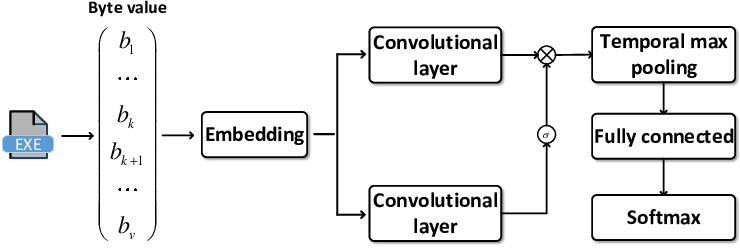

Portable executable (PE) files are a common Windows file type. PE files include the .exe,
.dll, and .sys files. All PE files are distinguished by having a PE header, which is a
header section of the code that instructs Windows on how to parse the subsequent code.
The fields from the PE header are often used as features in the detection of malware.

Finally, note that better architectures and choices of parameters are an open area of
research. Continuing, we are now free to select a batch size and begin training (Steps 8 and
9). The batch size is an important parameter that can affect both speed and stability of the
learning process. For our purposes, we have made a simple choice. We feed in a batch at a
time, and train our neural network.

In [81]:
def embed_bytes(byte): #function to embed a byte as a vector
    binary_string = "{0:08b}".format(byte)
    vec = np.zeros(8)
    for i in range(8):
        if binary_string[i] == "1":
            vec[i] = float(1) / 16
        else:
            vec[i] = -float(1) / 16
    return vec

In [82]:
from os import listdir
directories_with_label_PE = [("BenignPEFiles", 0), ("MaliciousPEFiles", 1)]
list_of_samples = []
labels_PE = []
for dataset_path, label in directories_with_label_PE:
    samples = [f for f in listdir(dataset_path)]
    for file in samples:
        file_path = os.path.join(dataset_path, file)
        list_of_samples.append(file_path)
        labels_PE.append(label)
print(labels_PE)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [83]:
print("Size: ",len(list_of_samples)," sample: ",list_of_samples[5])

Size:  111  sample:  BenignPEFiles\HxOutlook.exe


In [84]:
def read_file(file_path):
    """Read the binary sequence of a file."""
    with open(file_path, "rb") as binary_file:
        return binary_file.read()

In [100]:
max_size = 15000
num_samples = len(list_of_samples)
X = np.zeros((num_samples, 8, max_size))
Y = np.asarray(labels_PE)
file_num = 0
for file in list_of_samples:
    sample_byte_sequence = read_file(file)
    for i in range(min(max_size, len(sample_byte_sequence))):
        X[file_num, :, i] = embed_bytes(sample_byte_sequence[i])
    file_num += 1

In [101]:
print("Size x: ",X.shape,"\n","sample:",X[0],"\n","Size Y",Y.shape,"\n", "sample:",Y[:100])

Size x:  (111, 8, 15000) 
 sample: [[-0.0625 -0.0625 -0.0625 ... -0.0625 -0.0625 -0.0625]
 [ 0.0625  0.0625  0.0625 ... -0.0625  0.0625 -0.0625]
 [-0.0625 -0.0625 -0.0625 ...  0.0625 -0.0625  0.0625]
 ...
 [ 0.0625 -0.0625 -0.0625 ...  0.0625 -0.0625 -0.0625]
 [-0.0625  0.0625  0.0625 ... -0.0625 -0.0625 -0.0625]
 [-0.0625  0.0625  0.0625 ...  0.0625 -0.0625 -0.0625]] 
 Size Y (111,) 
 sample: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]


In [102]:
from tensorflow.keras import optimizers
my_opt = optimizers.SGD(learning_rate=0.01, decay=1e-5, nesterov=True)

In [103]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = keras.Sequential([
    layers.Input(shape=(8, max_size)),
    layers.Conv1D(kernel_size=(128), filters=32, strides=(128), padding="same",activation="sigmoid"),
    layers.Conv1D(kernel_size=(128), filters=32, strides=(128), padding="same",activation="relu"),
    layers.GlobalMaxPool1D(),
    layers.Dense(16),
    layers.Dense(1,activation="sigmoid")
])

In [104]:
model.compile(optimizer=my_opt, loss="binary_crossentropy", metrics=["acc"])

In [105]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 32)             61440032  
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 32)             131104    
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 61,571,681
Trainable params: 61,571,681
Non-trainable params: 0
__________________________________________

In [106]:
batch_size = 16
model.fit(X,Y)

4/4 [==============================] - 17s 4s/step - loss: 0.6851 - acc: 0.6396


In [107]:
model.evaluate(X,Y)

4/4 [==============================] - 1s 139ms/step - loss: 0.6515 - acc: 0.8018


[0.6515315771102905, 0.8018018007278442]

In [ ]:
  model.train_on_batch(
        batch, Y[batch_num * batch_size : (batch_num + 1) * batch_size])

## LSTM for malware detection 

Deep learning based Sequential model for malware analysis using **Windows exe API Calls**

One approach to deal with malware protection problem is by identifying the malicious software and evaluating its behavior. 
All operating system API calls made to act by any software show the overall direction of this program. Whether this program is malware or not can be learned by examining these actions in-depth. If it is malware, then what is its malware family. The malware-made operating system API call is a data attribute, and the sequence in which those API calls are generated is also critical to detect the malware family. Performing specific API calls is a particular order that represents a behavior.

One of the deep learning methods LSTM (long-short term memory) has been commonly used in the processing of such time-sequential data.


In [38]:
import pandas as pd
malware_calls_df = pd.read_csv("calls.zip", compression="zip",
                               sep="\t", names=["API_Calls"])
malware_calls_df

,API_Calls
0,"292,291,292,291,291,291,291,291,291,291,291,29..."
1,"278,192,199,192,290,291,291,291,291,290,291,29..."
2,"290,291,51,34,232,238,220,221,220,69,69,66,80,..."
3,"292,291,292,291,291,291,291,291,291,291,291,29..."
4,"292,291,291,291,291,291,291,291,291,291,291,29..."
...,...
7102,"292,291,291,291,291,291,291,291,291,291,291,29..."
7103,"292,291,291,291,291,291,291,291,291,291,291,29..."
7104,"292,291,291,291,291,291,291,291,291,291,291,29..."
7105,"181,192,199,192,49,49,49,192,192,192,290,291,1..."


In [39]:
malware_calls_df.dtypes

API_Calls    object
dtype: object

In [40]:
malware_labels_df = pd.read_csv("types.zip", compression="zip",
                                sep="\t", names=["API_Labels"])
malware_labels_df.dtypes

API_Labels    object
dtype: object

In [41]:
malware_calls_df["API_Calls"] = malware_calls_df.API_Calls.apply(lambda x: " ".join(x.split(",")))
malware_calls_df["API_Calls"] 

0       292 291 292 291 291 291 291 291 291 291 291 29...
1       278 192 199 192 290 291 291 291 291 290 291 29...
2       290 291 51 34 232 238 220 221 220 69 69 66 80 ...
3       292 291 292 291 291 291 291 291 291 291 291 29...
4       292 291 291 291 291 291 291 291 291 291 291 29...
                              ...                        
7102    292 291 291 291 291 291 291 291 291 291 291 29...
7103    292 291 291 291 291 291 291 291 291 291 291 29...
7104    292 291 291 291 291 291 291 291 291 291 291 29...
7105    181 192 199 192 49 49 49 192 192 192 290 291 1...
7106    292 291 291 291 291 291 291 291 291 291 291 29...
Name: API_Calls, Length: 7107, dtype: object

In [42]:
malware_calls_df["API_Labels"] = malware_labels_df.API_Labels
malware_calls_df["API_Labels"] = malware_calls_df.API_Labels.apply(lambda x: 1 if x == "Virus" else 0)
malware_calls_df["API_Labels"]

0       0
1       0
2       0
3       0
4       0
       ..
7102    1
7103    1
7104    1
7105    1
7106    1
Name: API_Labels, Length: 7107, dtype: int64

In [43]:
max_words = 800
max_len = 100

X_lstm = malware_calls_df.API_Calls

X_lstm

0       292 291 292 291 291 291 291 291 291 291 291 29...
1       278 192 199 192 290 291 291 291 291 290 291 29...
2       290 291 51 34 232 238 220 221 220 69 69 66 80 ...
3       292 291 292 291 291 291 291 291 291 291 291 29...
4       292 291 291 291 291 291 291 291 291 291 291 29...
                              ...                        
7102    292 291 291 291 291 291 291 291 291 291 291 29...
7103    292 291 291 291 291 291 291 291 291 291 291 29...
7104    292 291 291 291 291 291 291 291 291 291 291 29...
7105    181 192 199 192 49 49 49 192 192 192 290 291 1...
7106    292 291 291 291 291 291 291 291 291 291 291 29...
Name: API_Calls, Length: 7107, dtype: object

In [44]:
Y_lstm = malware_calls_df.API_Labels.astype('category').cat.codes
Y_lstm

0       0
1       0
2       0
3       0
4       0
       ..
7102    1
7103    1
7104    1
7105    1
7106    1
Length: 7107, dtype: int8

In [45]:
X_lstm.shape

(7107,)

In [46]:
Y_lstm.shape

(7107,)

In [47]:
from keras.preprocessing.text import Tokenizer
import time
from keras.preprocessing import sequence
start = time.time()
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_lstm)
print('Found %s unique tokens.' % len(tok.word_index))
X_lstm = tok.texts_to_sequences(X_lstm.values)
X_lstm = sequence.pad_sequences(X_lstm, maxlen=max_len)
print('Shape of data tensor:', X_lstm.shape)
end = time.time()
print("TIME: " ,end-start,"s")

Found 278 unique tokens.
Shape of data tensor: (7107, 100)
TIME:  231.9198694229126 s


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
X_train_lstm, X_test_lstm, Y_train_lstm, Y_test_lstm = train_test_split(X_lstm, Y_lstm,test_size=0.15)


In [49]:
#encodage                                                    
le = LabelEncoder()
Y_train_enc_lstm = le.fit_transform(Y_train_lstm)
Y_train_enc_lstm = np_utils.to_categorical(Y_train_enc_lstm)
print("YTRAIN: ",Y_train_enc_lstm,"\n")
Y_test_enc_lstm = le.transform(Y_test_lstm)
Y_test_enc_lstm = np_utils.to_categorical(Y_test_enc_lstm)
print("YTEST:",Y_test_enc_lstm,"\n")

YTRAIN:  [[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]] 

YTEST: [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]] 



In [50]:
import tensorflow as tf
from keras.layers import SpatialDropout1D,LSTM,Dense,Dropout,Embedding
from tensorflow.keras.models import Sequential

model_lstm = Sequential([
    Embedding(max_words, 300, input_length=max_len),
    SpatialDropout1D(0.1),
    LSTM(32, dropout=0.1, recurrent_dropout=0.1,
                   return_sequences=True, activation="softsign"),
    LSTM(32, dropout=0.1, activation="softsign", return_sequences=True),
    LSTM(32, dropout=0.1, activation="softsign"),
    Dense(128, activation="softsign"),
    Dropout(0.1),
    Dense(256, activation="softsign"),
    Dropout(0.1),
    Dense(128, activation="softsign"),
    Dropout(0.1),
    Dense(1, name='out_layer', activation="linear")])

In [51]:
model_lstm.compile(loss='mse', optimizer="rmsprop",
              metrics=['acc'])
start=time.time()
history = model_lstm.fit(X_train_lstm, Y_train_lstm, batch_size=1000, epochs=10,
                    validation_data=(X_test_lstm, Y_test_lstm), verbose=1)
end=time.time()
time_lstm=end-start
print("TIME Trainin: ",time_lstm)

Epoch 1/10
7/7 [==============================] - 55s 5s/step - loss: 0.1348 - acc: 0.8594 - val_loss: 0.1334 - val_acc: 0.8575
Epoch 2/10
7/7 [==============================] - 24s 3s/step - loss: 0.1153 - acc: 0.8594 - val_loss: 0.1092 - val_acc: 0.8566
Epoch 3/10
7/7 [==============================] - 23s 3s/step - loss: 0.1137 - acc: 0.8636 - val_loss: 0.1081 - val_acc: 0.8566
Epoch 4/10
7/7 [==============================] - 28s 4s/step - loss: 0.1008 - acc: 0.8714 - val_loss: 0.1003 - val_acc: 0.8754
Epoch 5/10
7/7 [==============================] - 26s 4s/step - loss: 0.0945 - acc: 0.8843 - val_loss: 0.1005 - val_acc: 0.8885
Epoch 6/10
7/7 [==============================] - 26s 4s/step - loss: 0.0913 - acc: 0.8912 - val_loss: 0.1004 - val_acc: 0.8838
Epoch 7/10
7/7 [==============================] - 28s 4s/step - loss: 0.0864 - acc: 0.9007 - val_loss: 0.1563 - val_acc: 0.7844
Epoch 8/10
7/7 [==============================] - 27s 4s/step - loss: 0.0973 - acc: 0.8755 - val_loss: 0

In [52]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          240000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 300)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100, 32)           42624     
                                                                 
 lstm_1 (LSTM)               (None, 100, 32)           8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                        

In [81]:
ltstm_tr_acc=model_lstm.evaluate(X_train_lstm,Y_train_lstm)

189/189 [==============================] - 8s 42ms/step - loss: 0.0757 - acc: 0.9124


In [82]:
lstm_te_acc=model_lstm.evaluate(X_test_lstm,Y_test_lstm)

34/34 [==============================] - 2s 48ms/step - loss: 0.0954 - acc: 0.8894


In [62]:
from sklearn.metrics import confusion_matrix
import numpy as np
y_test_pred_lstm =np.round(model_lstm.predict(X_test_lstm),0)
cm = confusion_matrix(Y_test_lstm, y_test_pred_lstm)

In [63]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,title,normalize=False,cmap=plt.cm.Reds):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


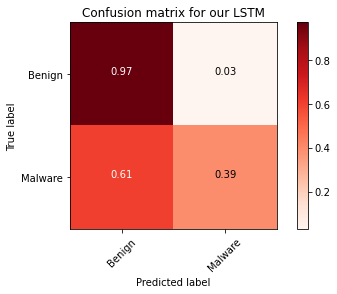

In [65]:
types=['Benign','Malware']
plot_confusion_matrix(cm, types,normalize=True,title='Confusion matrix for our LSTM')
plt.savefig("confusion_matrix.png")
plt.show()

Confusion matrix, without normalization


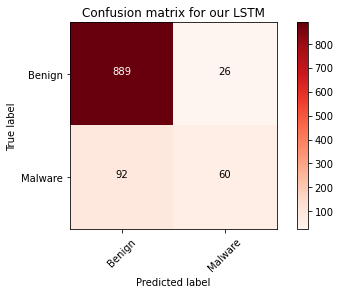

In [66]:
plot_confusion_matrix(cm, types,normalize=False,title='Confusion matrix for our LSTM')
plt.savefig("confusion_matrix.png")
plt.show()

In [67]:
from sklearn.metrics import classification_report
classification_metrics = classification_report(Y_test_lstm, y_test_pred_lstm, target_names=types )
print(classification_metrics)

              precision    recall  f1-score   support

      Benign       0.91      0.97      0.94       915
     Malware       0.70      0.39      0.50       152

    accuracy                           0.89      1067
   macro avg       0.80      0.68      0.72      1067
weighted avg       0.88      0.89      0.88      1067



#### GENERALITIES ABOUT OUR MODELS

In [85]:
overview_model = {}

overview_model['time']=time_pip,220.25,time_lstm
overview_model['train_acc ']=mi_pipeline.score(X_train, y_train),0.8234512,ltstm_tr_acc[1]
overview_model['test_acc ']=mi_pipeline.score(X_test, y_test),0.80167324,lstm_te_acc[1]


In [93]:
import pandas as pd
index=['Classification of API run time behavior','MALCONV for PE files analysis','Classification on API calls']
df_result=pd.DataFrame(overview_model, index=index)
df_result

,time,train_acc,test_acc
Classification of API run time behavior,80.762453,0.935775,0.861996
MALCONV for PE files analysis,220.250000,0.823451,0.801673
Classification on API calls,291.575274,0.912417,0.889410


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

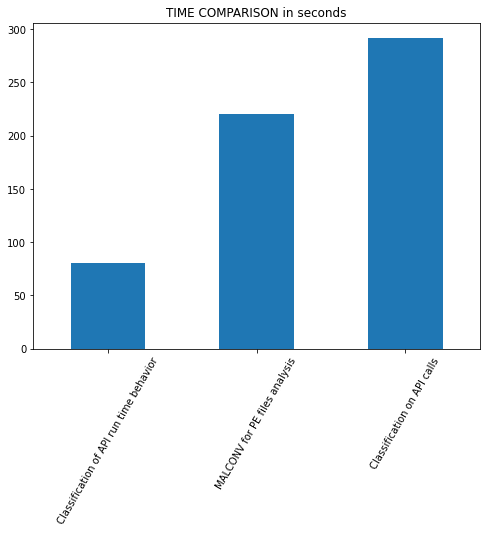

In [101]:
plt.figure(figsize =(8, 6))
df_result['time'].plot(kind="bar")
plt.title("TIME COMPARISON in seconds")
plt.xticks(rotation=60)

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

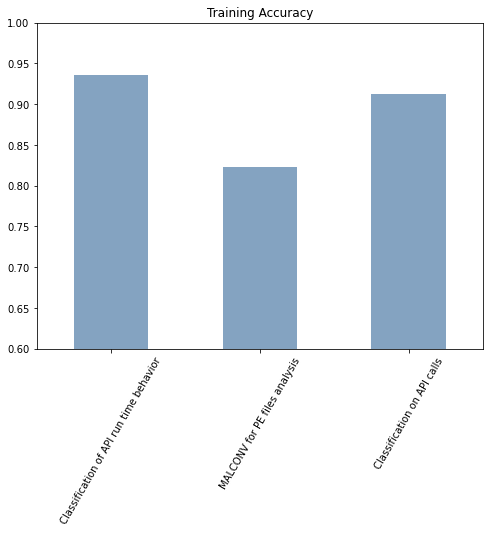

In [111]:
plt.figure(figsize =(8, 6))
df_result['train_acc '].plot(kind="bar",color=(0.2, 0.4, 0.6, 0.6))
plt.ylim(0.6,1)
plt.title("Training Accuracy")
plt.xticks(rotation=60)

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

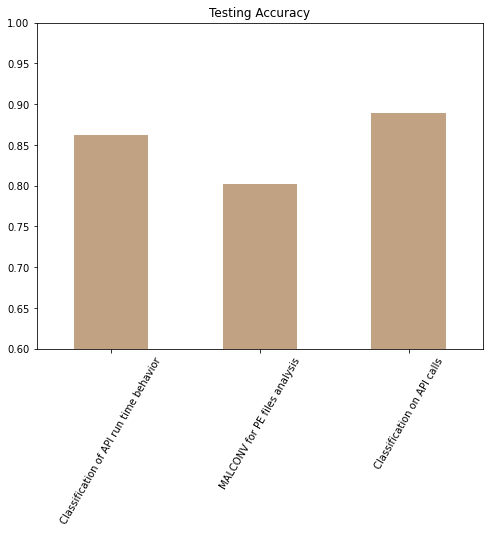

In [110]:
plt.figure(figsize =(8, 6))
df_result['test_acc '].plot(kind="bar",color=(0.6, 0.4, 0.2, 0.6))
plt.ylim(0.6,1)
plt.title("Testing Accuracy")
plt.xticks(rotation=60)